<a href="https://colab.research.google.com/github/samservo09/bioinformatics-bipolar-drug-discovery/blob/main/2-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bioinformatics: Drug discovery on CaM-kinase kinase beta protein

## Install necessary packages/libraries

**RDKit** - collection of open-source cheminformatics and machine-learning software written in C++ and Python.

In [1]:
# install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-10-12 01:55:28--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   121MB/s    in 0.7s    

2024-10-12 01:55:29 (121 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=

## Load bioactivity data

In [4]:
import pandas as pd

In [2]:
! wget https://raw.githubusercontent.com/samservo09/bioinformatics-bipolar-drug-discovery/refs/heads/main/data/CaMKK2_preprocessed_data.csv

--2024-10-12 02:01:15--  https://raw.githubusercontent.com/samservo09/bioinformatics-bipolar-drug-discovery/refs/heads/main/data/CaMKK2_preprocessed_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10464 (10K) [text/plain]
Saving to: ‘CaMKK2_preprocessed_data.csv.1’

CaMKK2_preprocessed 100%[===================>]  10.22K  --.-KB/s    in 0s      

2024-10-12 02:01:16 (76.0 MB/s) - ‘CaMKK2_preprocessed_data.csv.1’ saved [10464/10464]



In [33]:
df = pd.read_csv('CaMKK2_preprocessed_data.csv')

In [34]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL319620,O=C(O)c1cc(NCc2cc(O)ccc2O)ccc1O,200.00,active
1,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,0.04,active
2,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,10.00,active
3,CHEMBL1234833,CC(C)c1cnn2c(NCc3ccccc3)cc(N[C@@H](CO)[C@H](O)...,2450.00,intermediate
4,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,10000.00,inactive
...,...,...,...,...
128,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,10000.00,inactive
129,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,1600.00,intermediate
130,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,27000.00,inactive
131,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,30.00,active


## Calculate descriptors

**Lipinski descriptors** - "Rule of Five" <br>
- set of rules to evaluate the druglikeness of a compound <br>
- druglikeness is based on ADME (Absorption, Distribution, Metabolism, and Excretion) aka "pharmacokinetic profile" <br>

**Rule of Five** <br>
*   Molecular weight < 500 Dalton
*   Octanol-water partition coefficient (LogP) < 5
*   Hydrogen bond donors < 5
*   Hydrogen bond acceptors < 10



*Note: compounds that violate more than 1 of these rules are likely to have poor absorpiton making them less suitable for oral administration as drugs.*

Further explanation for each rule: <br>
*   **Molecules with higher molecular weights** tend to have **difficulty passing through** cell membranes, which is crucial for absorption and distribution in the body <br>
*   **LogP is a way to measure if a molecule prefers to dissolve in fat (octanol) or in water.** If it likes fat a lot (high LogP), it can be hard for it to mix with water, making it difficult for our body to absorb it. <br>
*   When molecules have groups like OH or NH, they stick to water really well. This **strong sticking can make it harder for those molecules to get through the protective barriers** (membranes) of cells.<br>
*   Hydrogen bond acceptors, like oxygen and nitrogen, can attract water. This can make it **difficult for certain molecules to pass through the cell's protective barrier** (membrane).

In [8]:
! pip install -q rdkit

     |████████████████████████████████| 29.5 MB 1.3 MB/s 


In [9]:
# import libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [35]:
# calculate descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [36]:
# turn the canonical smiles column into a dataframe
df_lipinski = lipinski(df.canonical_smiles)

In [37]:
# lipinski dataframe
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,275.260,2.11370,5.0,5.0
1,374.352,3.38100,2.0,5.0
2,374.352,3.38100,2.0,5.0
3,385.468,1.59080,5.0,8.0
4,346.416,1.45030,2.0,7.0
...,...,...,...,...
128,349.773,5.51340,1.0,3.0
129,397.474,6.82602,1.0,3.0
130,349.773,5.51340,1.0,3.0
131,397.474,6.82602,1.0,3.0


In [38]:
# original dataframe
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL319620,O=C(O)c1cc(NCc2cc(O)ccc2O)ccc1O,200.00,active
1,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,0.04,active
2,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,10.00,active
3,CHEMBL1234833,CC(C)c1cnn2c(NCc3ccccc3)cc(N[C@@H](CO)[C@H](O)...,2450.00,intermediate
4,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,10000.00,inactive
...,...,...,...,...
128,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,10000.00,inactive
129,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,1600.00,intermediate
130,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,27000.00,inactive
131,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,30.00,active


In [39]:
# combine the two to have the standard value and bioactivity class
df_combined = pd.concat([df,df_lipinski], axis=1)

In [40]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL319620,O=C(O)c1cc(NCc2cc(O)ccc2O)ccc1O,200.00,active,275.260,2.11370,5.0,5.0
1,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,0.04,active,374.352,3.38100,2.0,5.0
2,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,10.00,active,374.352,3.38100,2.0,5.0
3,CHEMBL1234833,CC(C)c1cnn2c(NCc3ccccc3)cc(N[C@@H](CO)[C@H](O)...,2450.00,intermediate,385.468,1.59080,5.0,8.0
4,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,10000.00,inactive,346.416,1.45030,2.0,7.0
...,...,...,...,...,...,...,...,...
128,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,10000.00,inactive,349.773,5.51340,1.0,3.0
129,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,1600.00,intermediate,397.474,6.82602,1.0,3.0
130,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,27000.00,inactive,349.773,5.51340,1.0,3.0
131,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,30.00,active,397.474,6.82602,1.0,3.0


## Convert IC50 to pIC50

To allow **IC50** data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially **-log10(IC50)**.

In [41]:
! pip install -q seaborn
! pip install -q matplotlib

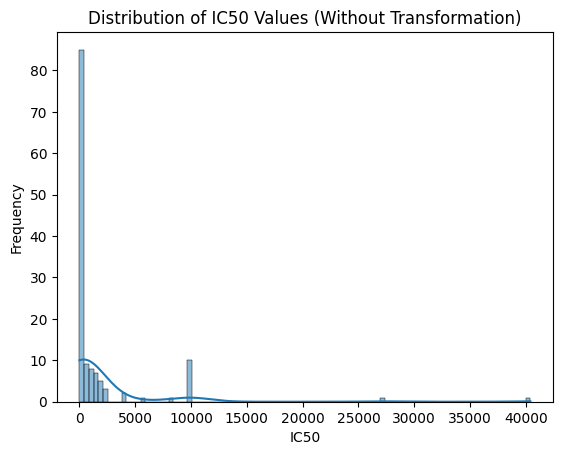

In [60]:
# distribution of ic50 values without transformation
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_combined['standard_value'], kde=True)
plt.xlabel('IC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 Values (Without Transformation)')
plt.show()

In [56]:
# accepts dataframe as input to apply log transformation (negative logarithmic scale)
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

*Note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.*

In [44]:
df_combined.standard_value.describe()

,standard_value
count,133.000000
mean,1792.817932
std,4868.718175
min,0.040000
25%,23.000000
50%,190.000000
75%,1100.000000
max,40400.000000


In [49]:
# need to cap the max value to 100 million to have positive values
-np.log10( (10**-9)* 100000000 )

1.0

In [28]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [52]:
# normalize the standard value column with max value of 100 million
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    # Changed code: Use axis=1 instead of 1
    x = input.drop('standard_value', axis=1)

    return x

In [53]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL319620,O=C(O)c1cc(NCc2cc(O)ccc2O)ccc1O,active,275.260,2.11370,5.0,5.0,200.00
1,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,active,374.352,3.38100,2.0,5.0,0.04
2,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,active,374.352,3.38100,2.0,5.0,10.00
3,CHEMBL1234833,CC(C)c1cnn2c(NCc3ccccc3)cc(N[C@@H](CO)[C@H](O)...,intermediate,385.468,1.59080,5.0,8.0,2450.00
4,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,inactive,346.416,1.45030,2.0,7.0,10000.00
...,...,...,...,...,...,...,...,...
128,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,inactive,349.773,5.51340,1.0,3.0,10000.00
129,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,intermediate,397.474,6.82602,1.0,3.0,1600.00
130,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,inactive,349.773,5.51340,1.0,3.0,27000.00
131,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,active,397.474,6.82602,1.0,3.0,30.00


In [54]:
# summary of capped max value
df_norm.standard_value_norm.describe()

,standard_value_norm
count,133.000000
mean,1792.817932
std,4868.718175
min,0.040000
25%,23.000000
50%,190.000000
75%,1100.000000
max,40400.000000


In [57]:
# apply the log transformation to the normalized df
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL319620,O=C(O)c1cc(NCc2cc(O)ccc2O)ccc1O,active,275.260,2.11370,5.0,5.0,6.698970
1,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,active,374.352,3.38100,2.0,5.0,10.397940
2,CHEMBL265470,CC(=O)O.O=C(O)c1ccc2c3c1cccc3c(=O)n1c3ccccc3nc21,active,374.352,3.38100,2.0,5.0,8.000000
3,CHEMBL1234833,CC(C)c1cnn2c(NCc3ccccc3)cc(N[C@@H](CO)[C@H](O)...,intermediate,385.468,1.59080,5.0,8.0,5.610834
4,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,inactive,346.416,1.45030,2.0,7.0,5.000000
...,...,...,...,...,...,...,...,...
128,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,inactive,349.773,5.51340,1.0,3.0,5.000000
129,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,intermediate,397.474,6.82602,1.0,3.0,5.795880
130,CHEMBL4787282,O=C(O)c1ccc(-c2coc3ncc(-c4ccccc4)cc23)cc1Cl,inactive,349.773,5.51340,1.0,3.0,4.568636
131,CHEMBL4745471,Cc1cccc(-c2cnc3occ(-c4ccc(C(=O)O)c(C5CCCC5)c4)...,active,397.474,6.82602,1.0,3.0,7.522879


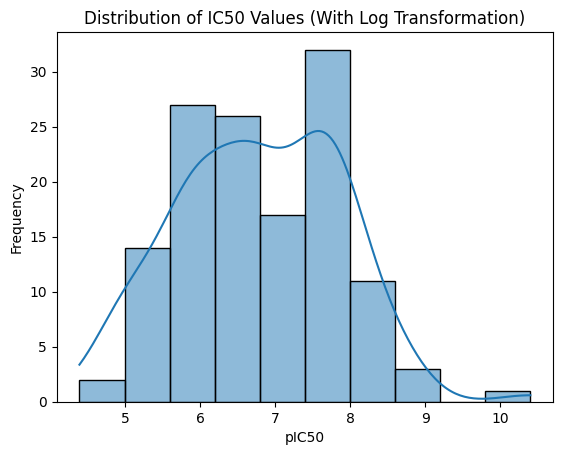

In [61]:
# distribution of ic50 values with transformation
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_final['pIC50'], kde=True)
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 Values (With Log Transformation)')
plt.show()

**Explanation:** <br>
*   The range is more compressed. <br>
*   The distribution of pIC50 values is closer to a normal distribution (bell-shaped curve)


